# Training two types of images on two branches of DNN and CNN to combine them at fully connected layers. The image types are x-ray images and lung mask images. There are three classes to predict: COVID, Non-COVID, and Normal

In [2]:
%load_ext tensorboard
# %tensorboard --logdir /kaggle/working/logs/fit/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import shutil
import ast

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, BatchNormalization, Dropout
from datetime import datetime
from packaging import version
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import label_binarize


import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report


print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.15.0


In [4]:
import tensorboard
tensorboard.__version__

'2.15.1'

In [3]:
x_ray_covid_dir = "data/x-ray/covid/"
x_ray_non_covid_dir = "data/x-ray/non-covid/"
x_ray_normal_dir = "data/x-ray/normal/"

mask_covid_dir = "data/mask/covid/"
mask_non_covid_dir = "data/mask/non-covid/"
mask_normal_dir = "data/mask/normal/"

old_x_ray_covid_dir = "data/Val/COVID-19/images/"
old_x_ray_non_covid_dir = "data/Val/Non-COVID/images/"
old_x_ray_normal_dir = "data/Val/Normal/images/"

old_mask_covid_dir = "data/Val/COVID-19/lung masks/"
old_mask_non_covid_dir = "data/Val/Non-COVID/lung masks/"
old_mask_normal_dir = "data/Val/Normal/lung masks/"

In [ ]:

#* Create x-ray directories if does not exist:
if not os.path.exists(x_ray_covid_dir):
     os.makedirs(os.path.dirname(x_ray_covid_dir), exist_ok=True)
if not os.path.exists(x_ray_non_covid_dir):
     os.makedirs(os.path.dirname(x_ray_non_covid_dir), exist_ok=True)
if not os.path.exists(x_ray_normal_dir):
     os.makedirs(os.path.dirname(x_ray_normal_dir), exist_ok=True)

#* Create mask images directories if does not exist:
if not os.path.exists(mask_covid_dir):
     os.makedirs(os.path.dirname(mask_covid_dir), exist_ok=True)
if not os.path.exists(mask_non_covid_dir):
     os.makedirs(os.path.dirname(mask_non_covid_dir), exist_ok=True)
if not os.path.exists(mask_normal_dir):
     os.makedirs(os.path.dirname(mask_normal_dir), exist_ok=True)

#* Move files from old directory to new directory:
def move_files(old_dir, new_dir):
    imgs = os.listdir(old_dir)
    for img in imgs:
        shutil.move(os.path.join(old_dir, img), os.path.join(new_dir, img))

move_files(old_x_ray_covid_dir, x_ray_covid_dir)
move_files(old_x_ray_non_covid_dir, x_ray_non_covid_dir)
move_files(old_x_ray_normal_dir, x_ray_normal_dir)

move_files(old_mask_covid_dir, mask_covid_dir)
move_files(old_mask_non_covid_dir, mask_non_covid_dir)
move_files(old_mask_normal_dir, mask_normal_dir)

print(f"Separate Images dir made for x-rays and lung masks")

## Helper functions, used in both models

In [4]:
def get_datasets(params):
    #* Training dataset
    train_data = tf.keras.preprocessing.image_dataset_from_directory(
        directory=params.get('directory'),
        image_size=params.get('image_size'),
        validation_split=params.get('validation_split'),
        subset="training",
        seed=params.get('seed_of_covid'),
        color_mode=params.get('color_mode'),
        shuffle=params.get('shuffle'),
        batch_size=params.get('batch_size'))

    #* Testing dataset
    test_data = tf.keras.preprocessing.image_dataset_from_directory(
        directory=params.get('directory'),
        image_size=params.get('image_size'),
        validation_split=params.get('validation_split'),
        subset="validation", # * Validation set will not be agumented later
        seed=params.get('seed_of_covid'),
        color_mode=params.get('color_mode'),
        shuffle=params.get('shuffle'),
        batch_size=params.get('batch_size'))
    
    return train_data, test_data

In [5]:
def create_data_generator_orbs(base_dir, validation_split=0.2):
    image_generator_orb = ImageDataGenerator( #* The generatore Orb of covid
        rescale=1./255, #* Even though we know the data is in grayscale, we are not sure that all data are strictly in grayscale.
        rotation_range=20, 
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=validation_split  
    )

    train_generator_orb = image_generator_orb.flow_from_directory(
        base_dir,
        target_size=(256, 256),
        batch_size=32,
        color_mode='grayscale',
        class_mode='categorical',
        subset='training' 
    )

    validation_generator_orb = image_generator_orb.flow_from_directory(
        base_dir,
        target_size=(256, 256),
        batch_size=32,
        color_mode='grayscale',
        class_mode='categorical',
        subset='validation' # * Will not get augmented
    )

    return train_generator_orb, validation_generator_orb #* These are the python generator objects we can use later to get the images one by one

In [6]:
def get_training_data_from_generator_orb(x_ray_gen_orb, mask_gen_orb): #* Generators containing images data
    while True: #* Yield the input data and labels one by one in training phase through these generators
        x_ray_gen_orb_next = x_ray_gen_orb.next() #* Next item in x-ray orb
        mask_gen_orb_next = mask_gen_orb.next() #* Next item in lung mask orb
        yield [x_ray_gen_orb_next[0], mask_gen_orb_next[0]], x_ray_gen_orb_next[1] #* the first elements are the input images
        #* and the second element is the class labels. Since labels are same for x-ray and lung mask, we can give second element from either x-ray or lung mask list.

## X-rays data preprocessing

In [5]:
# * Parameters for x-ray
params = {
    'directory': 'data/x-ray/',
    'image_size': ast.literal_eval('(256, 256)'), #* To pass literal object i.e.(256, 256) not string object
    'validation_split': 0.2,
    'seed_of_covid': 477,
    'color_mode': 'grayscale',
    'shuffle': True,
    'batch_size': 32
}
    
train_data_x_ray, test_data_x_ray = get_datasets(params)

Found 5417 files belonging to 3 classes.
Using 4334 files for training.
Found 5417 files belonging to 3 classes.
Using 1083 files for validation.


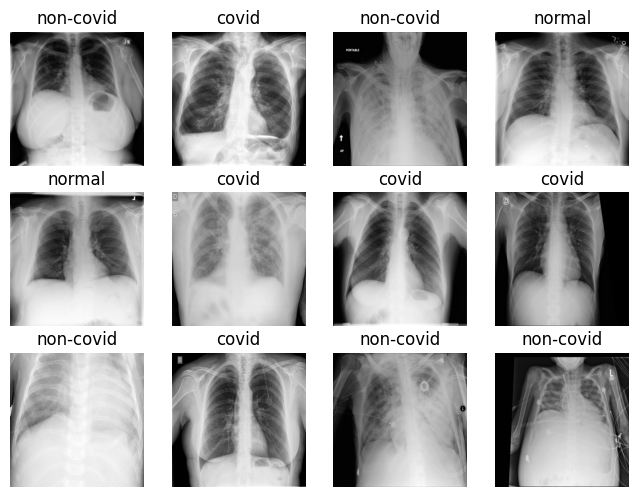

In [6]:
def show_images(dataset):
    plt.figure(figsize=(8, 8))

    for imgs, titles in dataset.take(1): #* Taking from batch 1
        for i in range(12):
            ax = plt.subplot(4, 4, i + 1)
            plt.title(dataset.class_names[titles[i]])
            plt.imshow(imgs[i], cmap='gray') #* With names and grayscale images
            plt.axis("off") #* To create a cleaner interface
    plt.show()

show_images(train_data_x_ray)

## Lung Masks data preprocessing

In [7]:
params = {
    'directory': 'data/mask/',
    'image_size': ast.literal_eval('(256, 256)'),
    'validation_split': 0.2,
    'seed_of_covid': 477,
    'color_mode': 'grayscale',
    'shuffle': True,
    'batch_size': 32
}

train_data_mask, test_data_mask = get_datasets(params)


Found 5417 files belonging to 3 classes.
Using 4334 files for training.
Found 5417 files belonging to 3 classes.
Using 1083 files for validation.


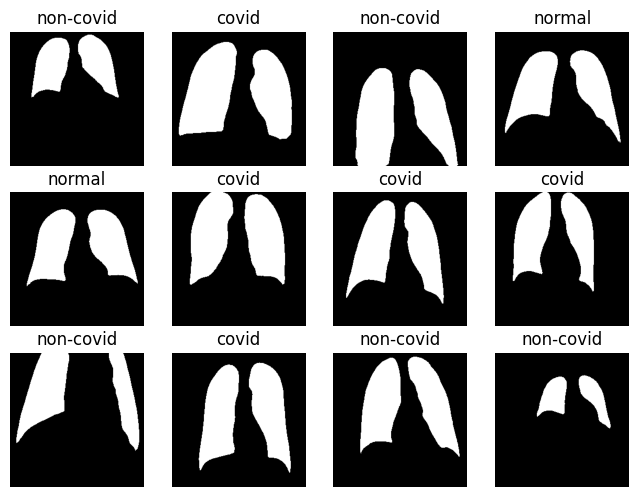

In [8]:
show_images(train_data_mask)

In [ ]:
print("X-ray class names:", train_data_x_ray.class_names)
print("Mask class names:", train_data_mask.class_names)


## DNN Functional Model with (2 Branches)

In [8]:
# Load training and validation data for both X-ray and mask images
x_ray_train, x_ray_val = create_data_generator_orbs('/kaggle/input/covid-ds/x-ray/')
mask_train, mask_val = create_data_generator_orbs('/kaggle/input/covid-ds/mask/')

Found 4335 images belonging to 3 classes.
Found 1082 images belonging to 3 classes.
Found 4335 images belonging to 3 classes.
Found 1082 images belonging to 3 classes.


## The Network:
### `We will use the Functional apis provided by keras instead of Sequential apis because we have a problem where we need different branches in our network`

In [43]:
# Branch 1 for x-rays
x_ray_input = Input(shape=(256, 256, 1), name="x-ray-branch-input") #* Yes, we can name our layer in functional apis
x_ray = Flatten(name="x-ray-flattened")(x_ray_input)
x_ray = Dense(1024, activation='relu', name="x-ray_dense_1")(x_ray)
x_ray = Dense(512, activation='relu', name="x-ray_dense_2")(x_ray)

# Branch 2 for masks
mask_input = Input(shape=(256, 256, 1), name="lung-mask-branch-input") 
mask = Flatten(name="lung-mask-flattened")(mask_input)
mask = Dense(1024, activation='relu', name="lung-mask_dense_1")(mask)
mask = Dense(512, activation='relu',  name="lung-mask_dense_2")(mask)

# Combining the branches
combined = concatenate([x_ray, mask]) #* We will try concatenate first, but we have bunch of other options we will try later
#* https://keras.io/api/layers/merging_layers/

# Fully connected layers
fc = Dense(256, activation='relu', name="fc_combined_1")(combined)
op = Dense(3, activation='softmax', name="output")(fc)

#* Set the model up
#* Since the model is expecting two inputs for two branches, we provide x_ray and mask input. Output will be the output layer
model_dnn_1 = Model(inputs=[x_ray_input, mask_input], outputs=op) 
model_dnn_1.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 x-ray-branch-input (InputL  [(None, 256, 256, 1)]        0         []                            
 ayer)                                                                                            
                                                                                                  
 lung-mask-branch-input (In  [(None, 256, 256, 1)]        0         []                            
 putLayer)                                                                                        
                                                                                                  
 x-ray-flattened (Flatten)   (None, 65536)                0         ['x-ray-branch-input[0][0]']  
                                                                                            

In [44]:
model_dnn_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

train_data = get_training_data_from_generator_orb(x_ray_train, mask_train) #* Yields the data from these two generator orbs

In [45]:
log_dir = "/kaggle/working/logs/dnn_fit/" + datetime.now().strftime("%Y%m%d-%H%M%S") #* Logs for tensorboard 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) #* tensorboard callback

history_dnn_1 = model_dnn_1.fit(
    train_data,
    steps_per_epoch=len(x_ray_train),
    validation_data=get_training_data_from_generator_orb(x_ray_val, mask_val),
    validation_steps=len(x_ray_val),
    epochs=10,
    callbacks=[tensorboard_callback],
)

Epoch 1/10
136/136 [==============================] - 90s 652ms/step - loss: 6.7106 - accuracy: 0.4161 - val_loss: 1.3392 - val_accuracy: 0.4427
Epoch 2/10
136/136 [==============================] - 89s 659ms/step - loss: 1.0569 - accuracy: 0.4978 - val_loss: 0.9641 - val_accuracy: 0.5980
Epoch 3/10
136/136 [==============================] - 88s 651ms/step - loss: 1.0076 - accuracy: 0.5223 - val_loss: 0.8434 - val_accuracy: 0.5841
Epoch 4/10
136/136 [==============================] - 87s 641ms/step - loss: 1.0383 - accuracy: 0.5073 - val_loss: 0.8222 - val_accuracy: 0.6294
Epoch 5/10
136/136 [==============================] - 84s 623ms/step - loss: 0.9658 - accuracy: 0.5391 - val_loss: 0.8303 - val_accuracy: 0.6155
Epoch 6/10
136/136 [==============================] - 80s 594ms/step - loss: 0.9780 - accuracy: 0.5301 - val_loss: 1.0376 - val_accuracy: 0.5203
Epoch 7/10
136/136 [==============================] - 71s 525ms/step - loss: 0.9678 - accuracy: 0.5379 - val_loss: 0.9697 - val_ac

### Let's train the dnn_model_1 to few more epoch

In [83]:
log_dir = "./runs/" + datetime.now().strftime("%Y%m%d-%H%M%S") #* Logs for tensorboard 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) #* tensorboard callback

history_dnn_1 = model_dnn_1.fit(
    train_data,
    steps_per_epoch=len(x_ray_train),
    validation_data=get_training_data_from_generator_orb(x_ray_val, mask_val),
    validation_steps=len(x_ray_val),
    epochs=10,
    callbacks=[tensorboard_callback],
)

Epoch 1/10
136/136 [==============================] - 98s 725ms/step - loss: 0.9462 - accuracy: 0.5617 - val_loss: 0.7802 - val_accuracy: 0.6571
Epoch 2/10
136/136 [==============================] - 93s 687ms/step - loss: 0.9445 - accuracy: 0.5506 - val_loss: 0.8854 - val_accuracy: 0.5804
Epoch 3/10
136/136 [==============================] - 89s 657ms/step - loss: 0.9087 - accuracy: 0.5762 - val_loss: 0.8186 - val_accuracy: 0.6091
Epoch 4/10
136/136 [==============================] - 86s 640ms/step - loss: 0.9082 - accuracy: 0.5827 - val_loss: 0.7577 - val_accuracy: 0.6793
Epoch 5/10
136/136 [==============================] - 84s 625ms/step - loss: 0.9039 - accuracy: 0.5783 - val_loss: 0.8724 - val_accuracy: 0.5591
Epoch 6/10
136/136 [==============================] - 85s 626ms/step - loss: 0.9076 - accuracy: 0.5767 - val_loss: 0.8612 - val_accuracy: 0.6128
Epoch 7/10
136/136 [==============================] - 73s 539ms/step - loss: 0.9063 - accuracy: 0.5795 - val_loss: 0.8225 - val_ac

## Tensorboards do not work on kaggle because it was temporarily disable by kaggle as it was slowing down the notebook for users

### The following tensorboard code was taken from [here](https://www.kaggle.com/code/alvin369/predicting-math-functions/notebook#Setting-up-Tensorboard). It uses ngrok tunneling to host kaggle server's internal ip to public ip which we can utilize to see the tensorboard hosted on 6006 in kaggle's server.

In [12]:
# using the hard way 
# run tensorboard in kaggle server. and operate using public url

# download the files for ngrok
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip

# Run tensorboard as well as Ngrox (for tunneling as non-blocking processes)
import os
import multiprocessing


pool = multiprocessing.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
                        for cmd in [
                        f"tensorboard --logdir /kaggle/working/logs/fit --host 0.0.0.0 --port 6006 &",
                        "./ngrok http 6006 &",
                        "./ngrok authtoken AUTH_TOKEN"
                        ]]

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [119]:
!kill -9 "$(pgrep ngrok)"

In [67]:
!ps aux | grep ngrok

root        1302 91.0  0.0   3904  2784 pts/0    Ss+  22:04   0:00 /bin/bash -c ps aux | grep ngrok
root        1304  0.0  0.0   3316   648 pts/0    S+   22:04   0:00 grep ngrok


#### Since the notebook was old, the version of ngrok it installed was old, so we have to upgrade to the latest. The version didnot match the minimum supported version by kaggle

In [11]:
!rm -f ngrok ngrok-stable-linux-amd64.zip
!wget https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-3.2.0-linux-amd64.tgz
!tar xvzf ngrok-3.2.0-linux-amd64.tgz

--2024-02-19 04:10:46--  https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-3.2.0-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 54.161.241.46, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8760730 (8.4M) [application/octet-stream]
Saving to: 'ngrok-3.2.0-linux-amd64.tgz'

ngrok-3.2.0-linux-a 100%[===================>]   8.35M  46.1MB/s    in 0.2s    

2024-02-19 04:10:47 (46.1 MB/s) - 'ngrok-3.2.0-linux-amd64.tgz' saved [8760730/8760730]

ngrok


In [13]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://74ab-35-196-195-162.ngrok-free.app


## We lost all the logs for tensorboard except for last cnn because of the session restart in kaggle :(

## Model Tuning: 

`-- Add He initializers cuz Reluzzzz`

`-- Add more layers to capture complex features`

`-- Add dropouts to compensate for overfitting`

`-- Add batch normalizations for hopefully good generalizations`

`-- Early Stopping Callback if the model doesn't learn for patience 5`


In [100]:
#* UserWarning: The initializer HeNormal is unseeded and being called multiple times, 
#* which will return identical values each time (even if the initializer is unseeded). 
#* Please update your code to provide a seed to the initializer, or avoid using the 
#* same initializer instance more than once.

#* We will use different seeds in each layer for weight initialization because,
#* it will generate same weights for each layer if we only use HeNormal() without any seed.

#* HE Initializers are instantiated in each initialization step with unique seeds on each step

# Branch 1 for x-rays
x_ray_input = Input(shape=(256, 256, 1), name="x-ray-branch-input")
x_ray = Flatten(name="x-ray-flattened")(x_ray_input)
x_ray = Dense(1024, activation='relu', kernel_initializer=HeNormal(seed=901), name="x-ray_dense_1")(x_ray)
x_ray = BatchNormalization(name="x-ray-normalization_1")(x_ray)
x_ray = Dropout(0.4, name="x-ray_dropout_1")(x_ray)
x_ray = Dense(512, activation='relu', kernel_initializer=HeNormal(seed=17), name="x-ray_dense_2")(x_ray)
x_ray = BatchNormalization(name="x-ray-normalization_2")(x_ray)
x_ray = Dropout(0.3, name="x-ray_dropout_2")(x_ray)
x_ray = Dense(256, activation='relu', kernel_initializer=HeNormal(seed=7811), name="x-ray_dense_3")(x_ray)
x_ray = BatchNormalization(name="x-ray-normalization_3")(x_ray)
x_ray = Dropout(0.2, name="x-ray_dropout_3")(x_ray)

# Branch 2 for lung masks
mask_input = Input(shape=(256, 256, 1), name="lung-mask-branch-input")
mask = Flatten(name="lung-mask-flattened")(mask_input)
mask = Dense(1024, activation='relu', kernel_initializer=HeNormal(seed=10), name="lung-mask_dense_1")(mask)
mask = BatchNormalization(name="lung-mask-normalization_1")(mask)
mask = Dropout(0.4, name="lung-mask_dropout_1")(mask)
mask = Dense(512, activation='relu', kernel_initializer=HeNormal(seed=881), name="lung-mask_dense_2")(mask)
mask = BatchNormalization(name="lung-mask-normalization_2")(mask)
mask = Dropout(0.3, name="lung-mask_dropout_2")(mask)
mask = Dense(256, activation='relu', kernel_initializer=HeNormal(seed=1024), name="lung-mask_dense_3")(mask)
mask = BatchNormalization(name="lung-mask-normalization_3")(mask)
mask = Dropout(0.2, name="lung-mask_dropout_3")(mask)

# Combining the branches
combined = concatenate([x_ray, mask], name="concatenate_branches")

# Fully connected layers
fc = Dense(256, activation='relu', kernel_initializer=HeNormal(seed=777), name="fc_combined_1")(combined)
fc = BatchNormalization(name="combined-normalization_1")(fc)
fc = Dropout(0.2, name="combined_dropout_1")(fc)
op = Dense(3, activation='softmax', name="output")(fc)

# Set the model up
model_dnn_2 = Model(inputs=[x_ray_input, mask_input], outputs=op)
model_dnn_2.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 x-ray-branch-input (InputL  [(None, 256, 256, 1)]        0         []                            
 ayer)                                                                                            
                                                                                                  
 lung-mask-branch-input (In  [(None, 256, 256, 1)]        0         []                            
 putLayer)                                                                                        
                                                                                                  
 x-ray-flattened (Flatten)   (None, 65536)                0         ['x-ray-branch-input[0][0]']  
                                                                                            

### Compilations, callbacks and Train

In [104]:
model_dnn_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
train_data = get_training_data_from_generator_orb(x_ray_train, mask_train) #* Yields the data from these two generator orbs

#* CallBacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
log_dir = "/kaggle/working/logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S") #* Logs for tensorboard 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) #* tensorboard callback

In [105]:
#* Train model_dnn_2
history_dnn_2 = model_dnn_2.fit(
    train_data,
    steps_per_epoch=len(x_ray_train),
    validation_data=get_training_data_from_generator_orb(x_ray_val, mask_val),
    validation_steps=len(x_ray_val),
    epochs=25,
    callbacks=[early_stopping_callback],
)

Epoch 1/25
136/136 [==============================] - 77s 536ms/step - loss: 0.9208 - accuracy: 0.5850 - val_loss: 0.9386 - val_accuracy: 0.5545
Epoch 2/25
136/136 [==============================] - 71s 524ms/step - loss: 0.8937 - accuracy: 0.5889 - val_loss: 0.8060 - val_accuracy: 0.6211
Epoch 3/25
136/136 [==============================] - 70s 515ms/step - loss: 0.8620 - accuracy: 0.6141 - val_loss: 0.8431 - val_accuracy: 0.6109
Epoch 4/25
136/136 [==============================] - 68s 502ms/step - loss: 0.8548 - accuracy: 0.6159 - val_loss: 1.1420 - val_accuracy: 0.4510
Epoch 5/25
136/136 [==============================] - 65s 482ms/step - loss: 0.8493 - accuracy: 0.6150 - val_loss: 0.8277 - val_accuracy: 0.5970
Epoch 6/25
136/136 [==============================] - 59s 439ms/step - loss: 0.8403 - accuracy: 0.6249 - val_loss: 0.8011 - val_accuracy: 0.6118
Epoch 7/25
136/136 [==============================] - 60s 445ms/step - loss: 0.8100 - accuracy: 0.6424 - val_loss: 0.7862 - val_ac

## The increase in validation loss after epoch 7 implies that the model started to overfit. Early stopping stopped the training to prevent overfitting. It restored the weights from epoch 7, which is the epoch with the lowest validation loss. 

## Tuning 3 of the dnn model
`-- Add ReduceLROnPlateau callback to reduce the lr when there is no improvement in "patience" number of epoch`

` -- Increase dropout values`

`-- Start with low learning rate`

In [11]:

#* UserWarning: The initializer HeNormal is unseeded and being called multiple times, 
#* which will return identical values each time (even if the initializer is unseeded). 
#* Please update your code to provide a seed to the initializer, or avoid using the 
#* same initializer instance more than once.

#* We will use different seeds in each layer for weight initialization because,
#* it will generate same weights for each layer if we only use HeNormal() without any seed.

#* HE Initializers are instantiated in each initialization step with unique seeds on each step

# Branch 1 for x-rays
x_ray_input = Input(shape=(256, 256, 1), name="x-ray-branch-input")
x_ray = Flatten(name="x-ray-flattened")(x_ray_input)
x_ray = Dense(512, activation='relu', kernel_initializer=HeNormal(seed=22), name="x-ray_dense_1")(x_ray)
x_ray = BatchNormalization(name="x-ray-normalization_1")(x_ray)
x_ray = Dropout(0.5, name="x-ray_dropout_1")(x_ray)
x_ray = Dense(256, activation='relu', kernel_initializer=HeNormal(seed=1557), name="x-ray_dense_2")(x_ray)
x_ray = BatchNormalization(name="x-ray-normalization_2")(x_ray)
x_ray = Dropout(0.4, name="x-ray_dropout_2")(x_ray)
x_ray = Dense(128, activation='relu', kernel_initializer=HeNormal(seed=4567), name="x-ray_dense_3")(x_ray)
x_ray = BatchNormalization(name="x-ray-normalization_3")(x_ray)
x_ray = Dropout(0.3, name="x-ray_dropout_3")(x_ray)

# Branch 2 for lung masks
mask_input = Input(shape=(256, 256, 1), name="lung-mask-branch-input")
mask = Flatten(name="lung-mask-flattened")(mask_input)
mask = Dense(512, activation='relu', kernel_initializer=HeNormal(seed=1000), name="lung-mask_dense_1")(mask)
mask = BatchNormalization(name="lung-mask-normalization_1")(mask)
mask = Dropout(0.5, name="lung-mask_dropout_1")(mask)
mask = Dense(256, activation='relu', kernel_initializer=HeNormal(seed=8811), name="lung-mask_dense_2")(mask)
mask = BatchNormalization(name="lung-mask-normalization_2")(mask)
mask = Dropout(0.4, name="lung-mask_dropout_2")(mask)
mask = Dense(128, activation='relu', kernel_initializer=HeNormal(seed=14024), name="lung-mask_dense_3")(mask)
mask = BatchNormalization(name="lung-mask-normalization_3")(mask)
mask = Dropout(0.3, name="lung-mask_dropout_3")(mask)

# Combining the branches
combined = concatenate([x_ray, mask], name="concatenate_branches")

# Fully connected layers
fc = Dense(128, activation='relu', kernel_initializer=HeNormal(seed=777), name="fc_combined_1")(combined)
fc = BatchNormalization(name="combined-normalization_1")(fc)
fc = Dropout(0.3, name="combined_dropout_1")(fc)
op = Dense(3, activation='softmax', name="output")(fc)

# Set the model up
model_dnn_3 = Model(inputs=[x_ray_input, mask_input], outputs=op)
model_dnn_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 x-ray-branch-input (InputL  [(None, 256, 256, 1)]        0         []                            
 ayer)                                                                                            
                                                                                                  
 lung-mask-branch-input (In  [(None, 256, 256, 1)]        0         []                            
 putLayer)                                                                                        
                                                                                                  
 x-ray-flattened (Flatten)   (None, 65536)                0         ['x-ray-branch-input[0][0]']  
                                                                                              

In [16]:
optimizer = Adam(learning_rate=0.0001)
model_dnn_3.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

train_data = get_training_data_from_generator_orb(x_ray_train, mask_train) #* Yields the data from these two generator orbs

#* CallBacks
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
log_dir = "/kaggle/working/logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S") #* Logs for tensorboard 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) #* tensorboard callback

In [17]:
#* Train model_dnn_3
history_dnn_3 = model_dnn_3.fit(
    train_data,
    steps_per_epoch=len(x_ray_train),
    validation_data=get_training_data_from_generator_orb(x_ray_val, mask_val),
    validation_steps=len(x_ray_val),
    epochs=15,
    callbacks=[early_stopping_callback, reduce_lr_callback, tensorboard_callback],
)

Epoch 1/15


I0000 00:00:1708303098.523376    3913 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


136/136 [==============================] - 118s 813ms/step - loss: 1.6228 - accuracy: 0.3917 - val_loss: 1.4720 - val_accuracy: 0.3734 - lr: 1.0000e-04
Epoch 2/15
136/136 [==============================] - 69s 511ms/step - loss: 1.4894 - accuracy: 0.4318 - val_loss: 0.8826 - val_accuracy: 0.5869 - lr: 1.0000e-04
Epoch 3/15
136/136 [==============================] - 67s 496ms/step - loss: 1.4165 - accuracy: 0.4424 - val_loss: 1.3666 - val_accuracy: 0.4482 - lr: 1.0000e-04
Epoch 4/15
136/136 [==============================] - 66s 490ms/step - loss: 1.3688 - accuracy: 0.4572 - val_loss: 0.9076 - val_accuracy: 0.5887 - lr: 1.0000e-04
Epoch 5/15
136/136 [==============================] - 64s 474ms/step - loss: 1.3169 - accuracy: 0.4607 - val_loss: 0.8805 - val_accuracy: 0.6109 - lr: 1.0000e-04
Epoch 6/15
136/136 [==============================] - 60s 443ms/step - loss: 1.2646 - accuracy: 0.4690 - val_loss: 0.8443 - val_accuracy: 0.6211 - lr: 1.0000e-04
Epoch 7/15
136/136 [==================

In [20]:
#* More epoch
history_dnn_3 = model_dnn_3.fit(
    train_data,
    steps_per_epoch=len(x_ray_train),
    validation_data=get_training_data_from_generator_orb(x_ray_val, mask_val),
    validation_steps=len(x_ray_val),
    epochs=20,
    callbacks=[early_stopping_callback, reduce_lr_callback, tensorboard_callback],
)

Epoch 1/20
136/136 [==============================] - 68s 503ms/step - loss: 1.0232 - accuracy: 0.5405 - val_loss: 0.7533 - val_accuracy: 0.6811 - lr: 1.0000e-04
Epoch 2/20
136/136 [==============================] - 67s 497ms/step - loss: 1.0287 - accuracy: 0.5299 - val_loss: 0.7359 - val_accuracy: 0.6848 - lr: 1.0000e-04
Epoch 3/20
136/136 [==============================] - 68s 501ms/step - loss: 0.9953 - accuracy: 0.5416 - val_loss: 0.7305 - val_accuracy: 0.7015 - lr: 1.0000e-04
Epoch 4/20
136/136 [==============================] - 66s 492ms/step - loss: 0.9925 - accuracy: 0.5426 - val_loss: 0.7707 - val_accuracy: 0.6423 - lr: 1.0000e-04
Epoch 5/20
136/136 [==============================] - 63s 467ms/step - loss: 1.0001 - accuracy: 0.5382 - val_loss: 0.7520 - val_accuracy: 0.6728 - lr: 1.0000e-04
Epoch 6/20
136/136 [==============================] - 66s 492ms/step - loss: 0.9882 - accuracy: 0.5451 - val_loss: 0.7614 - val_accuracy: 0.6821 - lr: 1.0000e-04
Epoch 7/20
136/136 [========

## Predictions and Evaluations helpers

In [18]:
def model_evaluation(model, test_x_rays, test_masks, target_labels):
    # Make predictions
    predictions = model.predict([test_x_rays, test_masks])
    predicted_labels = np.argmax(predictions, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(target_labels, predicted_labels)
    precision = precision_score(target_labels, predicted_labels, average='weighted', zero_division=1)
    recall = recall_score(target_labels, predicted_labels, average='weighted', zero_division=1)
    f1 = f1_score(target_labels, predicted_labels, average='weighted', zero_division=1)

    # Calculate AUC
    auc = roc_auc_score(target_labels, predictions, multi_class='ovr')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(target_labels, predicted_labels)

    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1-score:{f1}")
    print(f"AUC:{auc}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    
    # Print classification report
    target_names = ['COVID-19', 'Non COVID-19', 'Normal']
    print(f"Classification Report:\n {classification_report(target_labels, predicted_labels, target_names=target_names)}")
    return accuracy, precision, recall, f1, auc, conf_matrix, predictions

In [19]:
def plot_roc_curve(target_labels, predictions):
    # Calculate ROC curve and area for all the classes
    n_classes = predictions.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(target_labels[:, i], predictions[:, i])
        roc_auc[i] = roc_auc_score(target_labels[:, i], predictions[:, i])

    # Plot ROC curve for each class
    plt.figure()
    colors = ['blue', 'red', 'green']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPr')
    plt.ylabel('TPr')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [20]:
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Target Labels')
    plt.title('Confusion Matrix')
    plt.show()

## Convert the validation data into ont-hot encoded labels

In [21]:
val_x_rays = []
val_masks = []
val_labels = []

#* Yield data from the generator orb
for _ in range(len(x_ray_val)):
    x_ray_batch, labels_batch = next(x_ray_val)
    mask_batch, _ = next(mask_val) #* labels for masks are same as labels for x-rays
    
    #* Append to the main lists
    val_x_rays.append(x_ray_batch)
    val_masks.append(mask_batch)
    val_labels.append(labels_batch)
    
#* All main lists To nparray
val_x_rays = np.vstack(val_x_rays)
val_masks = np.vstack(val_masks)
val_labels = np.vstack(val_labels)

target_labels = np.argmax(val_labels, axis=1)

In [54]:
accuracy, precision, recall, f1, auc, conf_marix, predictions = model_evaluation(model_dnn_3, val_x_rays, val_masks, target_labels)

34/34 [==============================] - 0s 9ms/step
Accuracy:0.7005545286506469
Precision:0.7157330933132923
Recall:0.7005545286506469
F1-score:0.6969583177111256
AUC:0.8540135793112595
Confusion Matrix:
[[295  46  35]
 [ 60 285  19]
 [127  37 178]]
Classification Report:
               precision    recall  f1-score   support

    COVID-19       0.61      0.78      0.69       376
Non COVID-19       0.77      0.78      0.78       364
      Normal       0.77      0.52      0.62       342

    accuracy                           0.70      1082
   macro avg       0.72      0.70      0.70      1082
weighted avg       0.72      0.70      0.70      1082



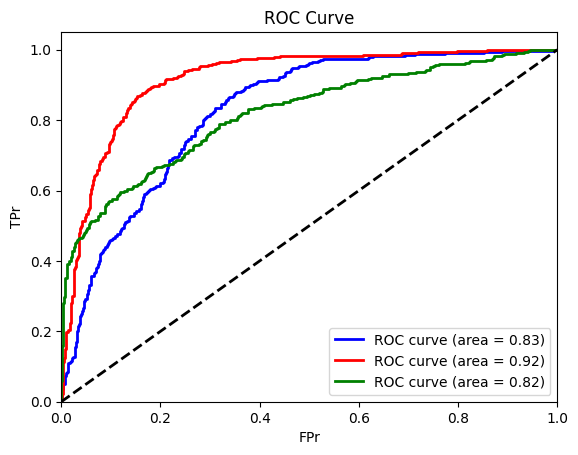

In [56]:
n_classes = 3 
#* Convert 1d target label array to 2d matrix format for multiclass ROC
target_labels_binarized = label_binarize(target_labels, classes=[0, 1, 2])
plot_roc_curve(target_labels_binarized, predictions)

## DNN Architecture

## --


## CNN Functional Model with (2 Branches)

In [7]:
# Load training and validation data for both X-ray and mask images
x_ray_train, x_ray_val = create_data_generator_orbs('/kaggle/input/covid-ds/x-ray/')
mask_train, mask_val = create_data_generator_orbs('/kaggle/input/covid-ds/mask/')

Found 4335 images belonging to 3 classes.
Found 1082 images belonging to 3 classes.
Found 4335 images belonging to 3 classes.
Found 1082 images belonging to 3 classes.


In [11]:
x_ray_input = Input(shape=(256, 256, 1))
x = Conv2D(32, (3, 3), activation='relu')(x_ray_input)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

mask_input = Input(shape=(256, 256, 1))
y = Conv2D(32, (3, 3), activation='relu')(mask_input)
y = Conv2D(32, (3, 3), activation='relu')(y)
y = MaxPooling2D((2, 2))(y)
y = Flatten()(y)

combined = concatenate([x, y])

z = Dense(512, activation='relu')(combined)
z = Dropout(0.3)(z)
z = Dense(256, activation='relu')(z)
z = Dropout(0.2)(z)
z = Dense(3, activation='softmax')(z)

model_cnn_1 = tf.keras.models.Model(inputs=[x_ray_input, mask_input], outputs=z)

model_cnn_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 254, 254, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 254, 254, 32)         320       ['input_2[0][0]']             
                                                                                              

In [ ]:
train_data = get_training_data_from_generator_orb(x_ray_train, mask_train)

logdir="/kaggle/working/logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history_cnn_3 = model_cnn_3.fit(
    train_data,
    steps_per_epoch=len(x_ray_train),
    validation_data=get_training_data_from_generator_orb(x_ray_val, mask_val),
    validation_steps=len(x_ray_val),
    epochs=30,
    callbacks=[tensorboard_callback],
)

Epoch 1/30


I0000 00:00:1708311365.943212     181 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1708311366.373792     181 hlo_rematerialization.cc:2946] Can't reduce memory use below 4.71GiB (5063416183 bytes) by rematerialization; only reduced to 9.69GiB (10404495392 bytes), down from 9.69GiB (10404495392 bytes) originally


136/136 [==============================] - 100s 684ms/step - loss: 6.7098 - accuracy: 0.3433 - val_loss: 1.1004 - val_accuracy: 0.3494
Epoch 2/30
136/136 [==============================] - 62s 457ms/step - loss: 1.1009 - accuracy: 0.3493 - val_loss: 1.0986 - val_accuracy: 0.3438
Epoch 3/30
136/136 [==============================] - 61s 451ms/step - loss: 1.0986 - accuracy: 0.3506 - val_loss: 1.0975 - val_accuracy: 0.3540
Epoch 4/30
136/136 [==============================] - 57s 423ms/step - loss: 1.1006 - accuracy: 0.3511 - val_loss: 1.0979 - val_accuracy: 0.3503
Epoch 5/30
136/136 [==============================] - 57s 421ms/step - loss: 1.0978 - accuracy: 0.3516 - val_loss: 1.0965 - val_accuracy: 0.3678
Epoch 6/30
136/136 [==============================] - 57s 420ms/step - loss: 1.0979 - accuracy: 0.3513 - val_loss: 1.0988 - val_accuracy: 0.3438
Epoch 7/30
 85/136 [=================>............] - ETA: 7s - loss: 1.0972 - accuracy: 0.3529

## The accuracy is stuck at around 0.35
- Lets reconstreuct the model

In [18]:
#* Branch 1 for x-rays
x_ray_input = Input(shape=(256, 256, 1))
x = Conv2D(32, (3, 3), activation='relu')(x_ray_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

#* Branch 2 for masks
mask_input = Input(shape=(256, 256, 1))
y = Conv2D(32, (3, 3), activation='relu')(mask_input)
y = MaxPooling2D((2, 2))(y)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = MaxPooling2D((2, 2))(y)
y = Flatten()(y)

#* Combining by concatenate. We can use other methods from tensorflow in case of tuning
combined = concatenate([x, y])

#* Add fully connected layers
z = Dense(256, activation='relu')(combined)
z = Dense(3, activation='softmax')(z)

model_cnn_2 = tf.keras.models.Model(inputs=[x_ray_input, mask_input], outputs=z)


In [19]:
model_cnn_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
train_data = get_training_data_from_generator_orb(x_ray_train, mask_train) #* Yields the data from these two generator orbs

history_cnn_2 = model.fit(
    train_data,
    steps_per_epoch=len(x_ray_train),
    validation_data=get_training_data_from_generator_orb(x_ray_val, mask_val),
    validation_steps=len(x_ray_val),
    epochs=20,
)

Epoch 1/20
136/136 [==============================] - 83s 582ms/step - loss: 1.3235 - accuracy: 0.4411 - val_loss: 0.8369 - val_accuracy: 0.6303
Epoch 2/20
136/136 [==============================] - 77s 567ms/step - loss: 0.9222 - accuracy: 0.5702 - val_loss: 0.7901 - val_accuracy: 0.6470
Epoch 3/20
136/136 [==============================] - 75s 555ms/step - loss: 0.8683 - accuracy: 0.6115 - val_loss: 0.8431 - val_accuracy: 0.6201
Epoch 4/20
136/136 [==============================] - 72s 531ms/step - loss: 0.8386 - accuracy: 0.6328 - val_loss: 0.9243 - val_accuracy: 0.5832
Epoch 5/20
136/136 [==============================] - 65s 479ms/step - loss: 0.8032 - accuracy: 0.6524 - val_loss: 0.8182 - val_accuracy: 0.6525
Epoch 6/20
136/136 [==============================] - 64s 469ms/step - loss: 0.7754 - accuracy: 0.6662 - val_loss: 0.7696 - val_accuracy: 0.6645
Epoch 7/20
136/136 [==============================] - 64s 476ms/step - loss: 0.7563 - accuracy: 0.6803 - val_loss: 0.7779 - val_ac

## Further tuning:
### Adding more conv layers
### Adding dropout and early stopping

In [10]:
x_ray_input = Input(shape=(256, 256, 1))
x = Conv2D(32, (3, 3), activation='relu')(x_ray_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

mask_input = Input(shape=(256, 256, 1))
y = Conv2D(32, (3, 3), activation='relu')(mask_input)
y = MaxPooling2D((2, 2))(y)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = MaxPooling2D((2, 2))(y)
y = Flatten()(y)

combined = concatenate([x, y])

z = Dense(256, activation='relu')(combined)
z = Dense(3, activation='softmax')(z)

model_cnn_2_1 = tf.keras.models.Model(inputs=[x_ray_input, mask_input], outputs=z)
model_cnn_2_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 254, 254, 32)         320       ['input_3[0][0]']             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 254, 254, 32)         320       ['input_4[0][0]']             
                                                                                            

In [14]:
model_cnn_2_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

train_data = get_training_data_from_generator_orb(x_ray_train, mask_train)

logdir="/kaggle/working/logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)


history_cnn_2_1 = model_cnn_3.fit(
    train_data,
    steps_per_epoch=len(x_ray_train),
    validation_data=get_training_data_from_generator_orb(x_ray_val, mask_val),
    validation_steps=len(x_ray_val),
    epochs=30,
    callbacks=[tensorboard_callback, early_stopping_callback],
)

Epoch 1/30
136/136 [==============================] - 94s 679ms/step - loss: 1.3294 - accuracy: 0.4955 - val_loss: 0.7869 - val_accuracy: 0.6580
Epoch 2/30
136/136 [==============================] - 74s 550ms/step - loss: 0.9069 - accuracy: 0.5716 - val_loss: 0.8567 - val_accuracy: 0.5980
Epoch 3/30
136/136 [==============================] - 73s 539ms/step - loss: 0.8675 - accuracy: 0.6129 - val_loss: 0.7958 - val_accuracy: 0.6100
Epoch 4/30
136/136 [==============================] - 70s 520ms/step - loss: 0.8384 - accuracy: 0.6314 - val_loss: 0.7412 - val_accuracy: 0.6895
Epoch 5/30
136/136 [==============================] - 65s 478ms/step - loss: 0.7972 - accuracy: 0.6577 - val_loss: 0.8433 - val_accuracy: 0.6294
Epoch 6/30
136/136 [==============================] - 67s 495ms/step - loss: 0.7483 - accuracy: 0.6854 - val_loss: 0.6807 - val_accuracy: 0.7126
Epoch 7/30
136/136 [==============================] - 62s 456ms/step - loss: 0.7370 - accuracy: 0.6872 - val_loss: 0.6596 - val_ac

In [15]:
x_ray_input = Input(shape=(256, 256, 1))
x = Conv2D(32, (3, 3), activation='relu')(x_ray_input)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

mask_input = Input(shape=(256, 256, 1))
y = Conv2D(32, (3, 3), activation='relu')(mask_input)
y = MaxPooling2D((2, 2))(y)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = MaxPooling2D((2, 2))(y)

combined = concatenate([x, y])

z = Flatten()(combined)
z = Dense(256, activation='relu')(z)
z = Dropout(0.3)(z)
z = Dense(3, activation='softmax')(z)

model_cnn_3 = tf.keras.models.Model(inputs=[x_ray_input, mask_input], outputs=z)
model_cnn_3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 254, 254, 32)         320       ['input_5[0][0]']             
                                                                                                  
 input_6 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_13 (Conv2D)          (None, 252, 252, 32)         9248      ['conv2d_12[0][0]']           
                                                                                            

In [16]:
model_cnn_3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

train_data = get_training_data_from_generator_orb(x_ray_train, mask_train)

logdir="/kaggle/working/logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)


history_cnn_3 = model_cnn_3.fit(
    train_data,
    steps_per_epoch=len(x_ray_train),
    validation_data=get_training_data_from_generator_orb(x_ray_val, mask_val),
    validation_steps=len(x_ray_val),
    epochs=30,
    callbacks=[tensorboard_callback, early_stopping_callback],
)

Epoch 1/30
136/136 [==============================] - 87s 572ms/step - loss: 1.2025 - accuracy: 0.4867 - val_loss: 0.8798 - val_accuracy: 0.5906
Epoch 2/30
136/136 [==============================] - 73s 542ms/step - loss: 0.9496 - accuracy: 0.5456 - val_loss: 0.8109 - val_accuracy: 0.6460
Epoch 3/30
136/136 [==============================] - 71s 523ms/step - loss: 0.9064 - accuracy: 0.5746 - val_loss: 0.7662 - val_accuracy: 0.6756
Epoch 4/30
136/136 [==============================] - 72s 534ms/step - loss: 0.8631 - accuracy: 0.6122 - val_loss: 0.7454 - val_accuracy: 0.6497
Epoch 5/30
136/136 [==============================] - 64s 476ms/step - loss: 0.8288 - accuracy: 0.6374 - val_loss: 0.7761 - val_accuracy: 0.6516
Epoch 6/30
136/136 [==============================] - 56s 411ms/step - loss: 0.7861 - accuracy: 0.6607 - val_loss: 0.8113 - val_accuracy: 0.6895
Epoch 7/30
136/136 [==============================] - 65s 480ms/step - loss: 0.7673 - accuracy: 0.6697 - val_loss: 0.6626 - val_ac

KeyboardInterrupt: 

In [23]:
accuracy, precision, recall, f1, auc, conf_marix, predictions = model_evaluation(model_cnn_3, val_x_rays, val_masks, target_labels)

34/34 [==============================] - 2s 46ms/step
Accuracy:0.7828096118299446
Precision:0.7833328207475699
Recall:0.7828096118299446
F1-score:0.7827803149904343
AUC:0.9150176842384177
Confusion Matrix:
[[300  55  25]
 [ 26 287  45]
 [ 49  35 260]]
Classification Report:
               precision    recall  f1-score   support

    COVID-19       0.80      0.79      0.79       380
Non COVID-19       0.76      0.80      0.78       358
      Normal       0.79      0.76      0.77       344

    accuracy                           0.78      1082
   macro avg       0.78      0.78      0.78      1082
weighted avg       0.78      0.78      0.78      1082



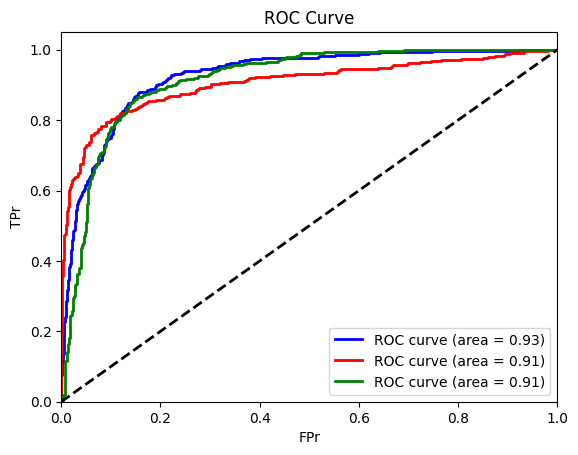

In [24]:
plot_roc_curve(target_labels_binarized, predictions)

## The model is learning well and there is no sign of overfitting until now, We can continue running this for further epoch to get more accuracy.

## References:
* https://keras.io/api/callbacks/reduce_lr_on_plateau/
* https://stackoverflow.com/questions/51889378/how-to-use-keras-reducelronplateau
* https://stackoverflow.com/questions/65869114/why-models-often-benefit-from-reducing-the-learning-rate-during-training
* https://discuss.pytorch.org/t/how-do-you-a-set-a-seed-for-weight-initialization-in-the-nn-module/4397
* https://machinelearningmastery.com/why-initialize-a-neural-network-with-random-weights/
* https://www.analyticsvidhya.com/blog/2021/03/introduction-to-batch-normalization/#:~:text=5.,faster%20convergence%20and%20better%20generalization.
* https://www.kaggle.com/code/alvin369/predicting-math-functions/notebook
* https://www.tensorflow.org/guide/keras/training_with_built_in_methods
* https://discuss.tensorflow.org/t/train-a-model-on-multiple-input-dataset/17829/4
* https://github.com/keras-team/keras/issues/2766
* https://www.frontiersin.org/articles/10.3389/fmed.2021.629134/full
* https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5
* https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
* https://www.kaggle.com/discussions/general/151033
* https://www.kaggle.com/discussions/general/108481
* https://wiki.python.org/moin/Generators
* https://blog.datumo.com/en/ai_tech/16035
* https://www.analyticsvidhya.com/blog/2021/07/understanding-sequential-vs-functional-api-in-keras/
* https://visualstudiomagazine.com/articles/2018/06/21/dnn-image-classification-using-keras.aspx
* https://www.tensorflow.org/tensorboard/get_started
* https://www.tensorflow.org/tensorboard/graphs
* https://stackoverflow.com/questions/54093903/concatenate-an-input-before-dense-layer-keras-with-tf-backend
* https://stackoverflow.com/questions/73146829/merge-multiple-cnn-models
* https://stackoverflow.com/questions/45723596/keras-how-to-concatenate-two-cnn
* https://stackoverflow.com/questions/62777173/adding-fully-connected-layers-to-cnn
* https://stackoverflow.com/questions/73111934/connecting-splitted-dense-layers-in-neural-networks-keras
* https://github.com/tensorflow/tensorflow/issues/53836
* https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
* https://pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/
* https://www.researchgate.net/post/How_to_combine_two_or_more_CNN_Models_and_get_Accuracy_of_the_resultant_Model#:~:text=What%20are%20the%20operations%20of,CNN%20architecture%20of%20Deep%20Learning%20%3F&text=Concatenation%20or%20combination%20is%20a,discovery%20of%20a%20new%20architecture.
* https://towardsdatascience.com/increase-the-accuracy-of-your-cnn-by-following-these-5-tips-i-learned-from-the-kaggle-community-27227ad39554
* https://stackoverflow.com/questions/46363927/concatenating-two-cnn-in-keras
* https://datascience.stackexchange.com/questions/116585/how-does-the-concatenation-work-between-cnn-and-normal-features
* https://groups.google.com/g/keras-users/c/A7tc1Whd-P8?pli=1
* https://stackoverflow.com/questions/31272772/convert-a-string-to-a-tuple
* https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
* https://stackoverflow.com/questions/53380560/combining-two-cnns
* https://forums.fast.ai/t/dense-vs-convolutional-vs-fully-connected-layers/191
* https://www.tensorflow.org/tutorials/load_data/images
* https://www.tensorflow.org/tutorials/images/cnn
* https://www.guru99.com/convnet-tensorflow-image-classification.html
* https://www.analyticsvidhya.com/blog/2020/02/learn-image-classification-cnn-convolutional-neural-networks-3-datasets/
* https://www.datacamp.com/tutorial/cnn-tensorflow-python
* https://medium.com/analytics-vidhya/image-classification-with-tensorflow-2a406bdfe0c1
* https://www.tensorflow.org/guide/data_performance
* https://keras.io/api/layers/merging_layers/dot/
* https://www.medrxiv.org/content/10.1101/2020.06.07.20124594v2.full
* 